# The Battle of Neighborhoods - Report

## 1. Introduction and Background

The main objective of this project is to propose a choice of the location to open a new local restaurant in Wellington, the capital of New Zealand. 

The committee of Cyber Community Club in Wellington (I made this up, it's not real...) has decided to use their club membership fees to open a restaurant (by investing) to better serve their members in a self-owned environment (their members do enjoy foods very much) and see how would the restaurant bring some extra revenue for the club. The committee has the enough money to start this new business, the only concern to them is finding a good location which covers a large amount of population with less competition (less other eateries). The location could be identified as the suburb in Wellington, as the suburb here is quite small.

## 2. Data and Methodology

The data I'll use to address this issue mainly consists of two data source:
1. Statistic data of each suburb in Wellington, from wellington city council specifically population (e.g. https://forecast.idnz.co.nz/wellington/population-summary)
2. Geopy data of coordinates of each suburb in Wellington, to be posted to Foursquare to get the venues
3. Foursquare venue data, to extract the venue count and category


Regarding methodology, below is a brief introduction about the steps that I'm going to take to fulfil the project purpose
1. Get a table of each suburbs and their population, better with their population growth as well, data preprocessing work is needed
2. Insert the coordinates of each suburb and use those to get venues near the suburb
3. Cluster them into groups using k-means into explainable clusters and pick the one with the least competition rival
4. Choose the best suburb from the cluster

### 2.1 Stats about suburbs in Wellington

Let's have a look about the population:

In [1]:
import pandas as pd

# this is a webpage with a table of Wellington's (capital of New Zealand) suburbs and population
df = pd.read_html('https://forecast.idnz.co.nz/wellington/population-summary')[0]
df = df.drop([0]).reset_index(drop=True)

df

Population summary                       \
                                      Wellington City Forecast year          
                                                 Area          2013   2018   
0                               Aro Valley - Highbury          3586   3805   
1                                          Berhampore          3683   3889   
2                                            Brooklyn          6729   6904   
3                             Churton Park - Glenside          6874   7552   
4   Grenada Village - Paparangi - Woodridge - Horo...          5652   6237   
5                                            Hataitai          6482   6842   
6                             Island Bay - Owhiro Bay          8791   9060   
7                                        Johnsonville         10482  11440   
8           Kaiwharawhara - Khandallah - Broadmeadows         10411  10737   
9                                              Karori         15210  15616   
10                                            Kelburn          4453   4704   
11                   Kilbirnie - Rongotai - Moa Point          5124   5286   
12                  Kingston - Mornington - Vogeltown          3053   3204   
13                                          Lyall Bay          2691   2814   
14                                  Miramar - Maupuia         11378  11763   
15                                            Mt Cook          6745   7852   
16                                        Mt Victoria          5134   5683   
17                               Newlands - Ngauranga          7543   8190   
18                                            Newtown          8714   9674   
19                              Ngaio - Crofton Downs          7394   7904   
20                                 Northland - Wilton          5597   5722   
21                     Ohariu - Makara - Makara Beach           811    823   
22                           Roseneath - Oriental Bay          3156   3389   
23                Seatoun - Karaka Bays - Breaker Bay          3802   4009   
24                 Southgate - Houghton Bay - Melrose          3920   4197   
25                                    Strathmore Park          3850   4061   
26               Tawa - Grenada North - Takapu Valley         14796  15371   
27                                             Te Aro         10028  11826   
28                                 Thorndon - Pipitea          4469   4775   
29                                          Wadestown          3664   3844   
30                                 Wellington Central          3277   3970   

                                                                    \
                                      Change between 2013 and 2043   
     2023   2028   2033   2038   2043                 Total change   
0    3875   3968   4031   4108   4163                         +577   
1    4206   4356   4464   4661   4880                       +1,197   
2    7014   7146   7136   7238   7309                         +580   
3    8708   9513   9653   9844  10057                       +3,183   
4    7389   8427   9162   9785  10503                       +4,851   
5    6879   6902   6877   6869   6906                         +424   
6    9398   9551   9559   9567   9622                         +831   
7   11838  12293  12768  13180  13674                       +3,192   
8   10819  10772  10710  10755  10810                         +399   
9   15724  15862  15955  16137  16405                       +1,195   
10   4855   4965   4992   4941   5034                         +581   
11   5469   5609   6079   6575   6952                       +1,828   
12   3248   3273   3303   3349   3396                         +343   
13   2856   2867   2900   2918   2950                         +259   
14  11808  11779  11967  12305  12772                       +1,394   
15   8384   9435   9748  10184  10614                       +3,869   
16   5853   5971   6025   6117   6266               

Ok, we only need some of the columns here, let's say: 
1. suburb name
2. population in 2018
3. the annual growth rate of population

In [2]:
df = df.iloc[:,[0,2,9]]
df.columns = ['Area','Pop_2018','Pop_CAGR']
df

,Area,Pop_2018,Pop_CAGR
0,Aro Valley - Highbury,3805,0.50
1,Berhampore,3889,0.94
2,Brooklyn,6904,0.28
3,Churton Park - Glenside,7552,1.28
4,Grenada Village - Paparangi - Woodridge - Horo...,6237,2.08
5,Hataitai,6842,0.21
6,Island Bay - Owhiro Bay,9060,0.30
7,Johnsonville,11440,0.89
8,Kaiwharawhara - Khandallah - Broadmeadows,10737,0.13
9,Karori,15616,0.25


Seems that some small suburbs have merged together but we need to evaluate them one by one, so let's split them into different suburb and take the average population for each

In [3]:
new_df = pd.DataFrame(columns=df.columns) # an empty dataframe

for m in range(len(df)):
    sub_list = df['Area'][m].split(' - ') # split merged suburbs into a list
    avg_pop = int(df['Pop_2018'][m] / len(sub_list)) # avg
    cagr = df['Pop_CAGR'][m] # cagr remains the same
    
    for sub in sub_list: # add each element as one row in a dict
        d = {}
        d['Area'] = sub
        d['Pop_2018'] = avg_pop
        d['Pop_CAGR'] = cagr

        new_df = new_df.append(d, ignore_index=True)
        
new_df

,Area,Pop_2018,Pop_CAGR
0,Aro Valley,1902,0.50
1,Highbury,1902,0.50
2,Berhampore,3889,0.94
3,Brooklyn,6904,0.28
4,Churton Park,3776,1.28
5,Glenside,3776,1.28
6,Grenada Village,1559,2.08
7,Paparangi,1559,2.08
8,Woodridge,1559,2.08
9,Horokiwi,1559,2.08


Ok, let's have a roughly look about the stats by ploting them into a bar chart to see each suburb's performance

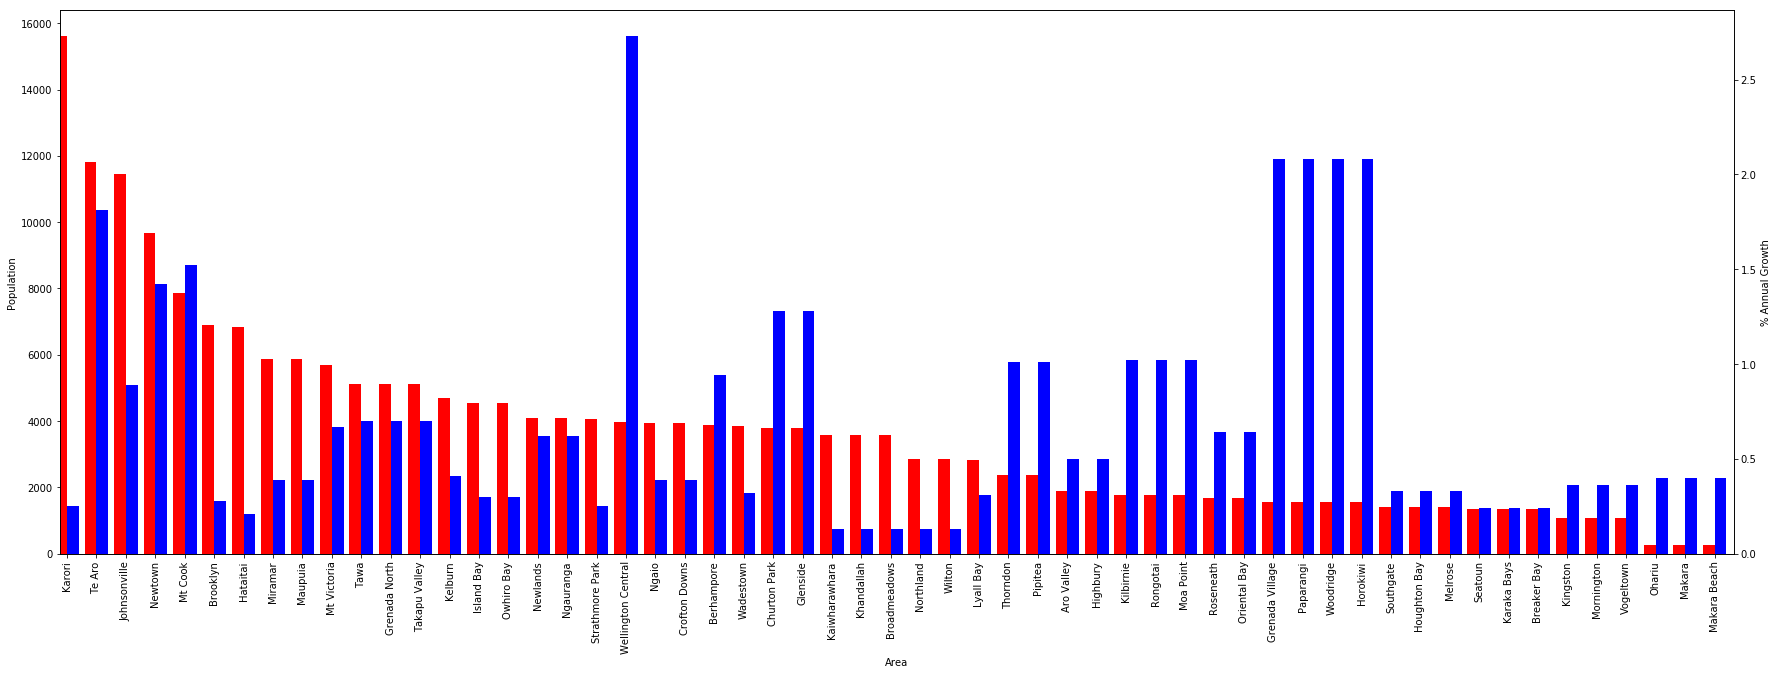

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

sorted_df = new_df.sort_values(by=['Pop_2018','Pop_CAGR'], ascending=False)
sorted_df = sorted_df.set_index('Area', drop=True)

fig = plt.figure()

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

sorted_df.Pop_2018.plot(kind='bar', color='red', ax=ax, width=width, position=1, figsize=(30,10))
sorted_df.Pop_CAGR.plot(kind='bar', color='blue', ax=ax2, width=width, position=0, figsize=(30,10))

ax.set_ylabel('Population')
ax2.set_ylabel('% Annual Growth')

plt.show()

### 2.2 Insert coordinates into dataframe matching each suburb

In [17]:
from geopy.geocoders import Nominatim

address = 'Wellington, New Zealand'

geolocator = Nominatim(user_agent='explorer')
lat = []
lon = []

for i in range(len(new_df)): # extract coordinates for each suburb
    location = geolocator.geocode(new_df['Area'][i] + ',' + address)
    lat.append(location.latitude)
    lon.append(location.longitude)

new_df.insert(3,'Latitude',lat)
new_df.insert(4,'Longitude',lon)

new_df.set_value(43, 'Latitude', -41.304241) # somehow geopy always returns me the coordinates of a tourist sight which shares the same name, so I just overwrite it...
new_df.set_value(43, 'Longitude', 174.831341)

new_df

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,Area,Pop_2018,Pop_CAGR,Latitude,Longitude
0,Aro Valley,1902,0.50,-41.295328,174.766580
1,Highbury,1902,0.50,-41.292798,174.756096
2,Berhampore,3889,0.94,-41.323264,174.774090
3,Brooklyn,6904,0.28,-41.306574,174.762354
4,Churton Park,3776,1.28,-41.208938,174.807138
5,Glenside,3776,1.28,-41.206097,174.812459
6,Grenada Village,1559,2.08,-41.208486,174.821901
7,Paparangi,1559,2.08,-41.214825,174.816750
8,Woodridge,1559,2.08,-41.216469,174.832599
9,Horokiwi,1559,2.08,-41.200949,174.845982


 Ok, let's have a look how the suburbs plotting on a map using the coordinates we just generated

In [18]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

# get the coordinates of Wellington, some vairiables can be found in the previous cell
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# initialize the map
map_Welly = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, area in zip(new_df['Latitude'], new_df['Longitude'], new_df['Area']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=750, # note here is 750 meters
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Welly)  
    
map_Welly

Solving environment: done

# All requested packages already installed.



### 2.3 Venues in each suburb

First define a function to extract the venue data

In [23]:
import requests

# define Foursquare credentials and version
CLIENT_ID = 'AE34T2DL5DO04V4MZUIALNRYDRYLHRRWX1KA3NIOJV5AMTWH'
CLIENT_SECRET = 'A4IE2PAA0ACWEOBLN2L10G3CBSSV4CCOOS2R0JUSX04OYBHR'
VERSION = '20180605'

# define a function to extract venue data
def getNearbyVenues(names, latitudes, longitudes, radius=1000): # kiwis can go ... quite far
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

And see the results with the function... see what venues we have here...

In [80]:
# invoke the function with area data
Welly = getNearbyVenues(names=new_df['Area'],
                                   latitudes=new_df['Latitude'],
                                   longitudes=new_df['Longitude']
                                  )

# check results
print(Welly.shape)
Welly.head(10)

(889, 7)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aro Valley,-41.295328,174.76658,Garage Project,-41.295393,174.767887,Brewery
1,Aro Valley,-41.295328,174.76658,Garage Project Taproom,-41.295338,174.766854,Beer Bar
2,Aro Valley,-41.295328,174.76658,Le Moulin Bakery,-41.294014,174.772075,Bakery
3,Aro Valley,-41.295328,174.76658,The Bresolin,-41.294981,174.771305,Restaurant
4,Aro Valley,-41.295328,174.76658,Vicbooks Café,-41.289315,174.768363,Café
5,Aro Valley,-41.295328,174.76658,Heyday Beer Co,-41.296725,174.773600,Bar
6,Aro Valley,-41.295328,174.76658,Logan Brown Restaurant & Bar,-41.294821,174.774813,Restaurant
7,Aro Valley,-41.295328,174.76658,Light House Cuba,-41.296095,174.775276,Indie Movie Theater
8,Aro Valley,-41.295328,174.76658,Fidel's Cafe,-41.295922,174.774232,Café
9,Aro Valley,-41.295328,174.76658,The Rogue & Vagabond,-41.293428,174.774846,Pub


There are too many detailed categories provided by Foursquare, I will **integrate all categories into 10 first-level category** provided by Foursquare

In [81]:
u = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
res = requests.get(u).json()

In [82]:
from pandas.io.json import json_normalize

cate_df = json_normalize(res['response']['categories'])
cate_df

,categories,icon.prefix,icon.suffix,id,name,pluralName,shortName
0,"[{'id': '56aa371be4b08b9a8d5734db', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/arts_en...,.png,4d4b7104d754a06370d81259,Arts & Entertainment,Arts & Entertainment,Arts & Entertainment
1,"[{'id': '4bf58dd8d48988d198941735', 'name': 'C...",https://ss3.4sqi.net/img/categories_v2/educati...,.png,4d4b7105d754a06372d81259,College & University,Colleges & Universities,College & Education
2,"[{'id': '52f2ab2ebcbc57f1066b8b3b', 'name': 'C...",https://ss3.4sqi.net/img/categories_v2/event/d...,.png,4d4b7105d754a06373d81259,Event,Events,Event
3,"[{'id': '503288ae91d4c4b30a586d67', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/food/de...,.png,4d4b7105d754a06374d81259,Food,Food,Food
4,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",https://ss3.4sqi.net/img/categories_v2/nightli...,.png,4d4b7105d754a06376d81259,Nightlife Spot,Nightlife Spots,Nightlife
5,"[{'id': '4f4528bc4b90abdf24c9de85', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/parks_o...,.png,4d4b7105d754a06377d81259,Outdoors & Recreation,Outdoors & Recreation,Outdoors & Recreation
6,"[{'id': '4e52d2d203646f7c19daa8ae', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4d4b7105d754a06375d81259,Professional & Other Places,Professional & Other Places,Professional
7,"[{'id': '5032891291d4c4b30a586d68', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/buildin...,.png,4e67e38e036454776db1fb3a,Residence,Residences,Residence
8,"[{'id': '52f2ab2ebcbc57f1066b8b56', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/shops/d...,.png,4d4b7105d754a06378d81259,Shop & Service,Shops & Services,Shops
9,"[{'id': '4bf58dd8d48988d1ed931735', 'name': 'A...",https://ss3.4sqi.net/img/categories_v2/travel/...,.png,4d4b7105d754a06379d81259,Travel & Transport,Travel & Transport,Travel


All the low-level categories are nested in the column 'categories'; 'name' is the first-level categories as shown above.

In [83]:
for i in range(len(Welly)):
    Welly.iat[i,6] = cate_df[cate_df['categories'].astype(str).str.contains(Welly.iat[i,6], na=False)].iat[0,4] # match the 'Venue Category' in Dataframe 'Welly' to 'categories' in Dataframe 'cate_df', and replace with the first-level category 
    
Welly.head(10)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aro Valley,-41.295328,174.76658,Garage Project,-41.295393,174.767887,Nightlife Spot
1,Aro Valley,-41.295328,174.76658,Garage Project Taproom,-41.295338,174.766854,Nightlife Spot
2,Aro Valley,-41.295328,174.76658,Le Moulin Bakery,-41.294014,174.772075,Food
3,Aro Valley,-41.295328,174.76658,The Bresolin,-41.294981,174.771305,Food
4,Aro Valley,-41.295328,174.76658,Vicbooks Café,-41.289315,174.768363,Food
5,Aro Valley,-41.295328,174.76658,Heyday Beer Co,-41.296725,174.773600,Arts & Entertainment
6,Aro Valley,-41.295328,174.76658,Logan Brown Restaurant & Bar,-41.294821,174.774813,Food
7,Aro Valley,-41.295328,174.76658,Light House Cuba,-41.296095,174.775276,Arts & Entertainment
8,Aro Valley,-41.295328,174.76658,Fidel's Cafe,-41.295922,174.774232,Food
9,Aro Valley,-41.295328,174.76658,The Rogue & Vagabond,-41.293428,174.774846,Arts & Entertainment


Find out the venue distribution of each area

In [86]:
# one hot encoding
Welly_onehot = pd.get_dummies(Welly[['Venue Category']], prefix="", prefix_sep="")

Welly_onehot['Area'] = Welly['Area'] 

# move area column to the first column
fixed_columns = [Welly_onehot.columns[-1]] + list(Welly_onehot.columns[:-1])
Welly_onehot = Welly_onehot[fixed_columns]

# group rows by area and by taking the mean of the frequency of occurrence of each category
Welly_grouped = Welly_onehot.groupby('Area').mean().reset_index()

Welly_grouped.head(10)

,Area,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Aro Valley,0.233333,0.000000,0.566667,0.200000,0.000000,0.0,0.000000,0.000000
1,Berhampore,0.333333,0.055556,0.166667,0.055556,0.277778,0.0,0.055556,0.055556
2,Breaker Bay,0.000000,0.000000,0.000000,0.250000,0.500000,0.0,0.250000,0.000000
3,Broadmeadows,0.200000,0.000000,0.400000,0.000000,0.000000,0.0,0.200000,0.200000
4,Brooklyn,0.312500,0.000000,0.375000,0.000000,0.062500,0.0,0.250000,0.000000
5,Churton Park,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.500000,0.000000
6,Crofton Downs,0.200000,0.000000,0.000000,0.000000,0.200000,0.0,0.400000,0.200000
7,Glenside,0.142857,0.000000,0.428571,0.000000,0.000000,0.0,0.428571,0.000000
8,Grenada North,0.250000,0.000000,0.000000,0.000000,0.000000,0.0,0.250000,0.500000
9,Grenada Village,0.200000,0.000000,0.200000,0.000000,0.000000,0.0,0.600000,0.000000


### 2.4 Cluster suburbs share similar venue composition

In [108]:
import numpy as np

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 8 # only return top 8 categories

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
area_venues_sorted = pd.DataFrame(columns=columns)
area_venues_sorted['Area'] = Welly_grouped['Area']

for ind in np.arange(Welly_grouped.shape[0]):
    area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Welly_grouped.iloc[ind, :], num_top_venues)

area_venues_sorted

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Aro Valley,Food,Arts & Entertainment,Nightlife Spot,Travel & Transport,Shop & Service,Professional & Other Places,Outdoors & Recreation,College & University
1,Berhampore,Arts & Entertainment,Outdoors & Recreation,Food,Travel & Transport,Shop & Service,Nightlife Spot,College & University,Professional & Other Places
2,Breaker Bay,Outdoors & Recreation,Shop & Service,Nightlife Spot,Travel & Transport,Professional & Other Places,Food,College & University,Arts & Entertainment
3,Broadmeadows,Food,Travel & Transport,Shop & Service,Arts & Entertainment,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University
4,Brooklyn,Food,Arts & Entertainment,Shop & Service,Outdoors & Recreation,Travel & Transport,Professional & Other Places,Nightlife Spot,College & University
5,Churton Park,Shop & Service,Food,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University,Arts & Entertainment
6,Crofton Downs,Shop & Service,Travel & Transport,Outdoors & Recreation,Arts & Entertainment,Professional & Other Places,Nightlife Spot,Food,College & University
7,Glenside,Shop & Service,Food,Arts & Entertainment,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University
8,Grenada North,Travel & Transport,Shop & Service,Arts & Entertainment,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,Food,College & University
9,Grenada Village,Shop & Service,Food,Arts & Entertainment,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University


Ok, seems like 'Food' venues are quite popular in this city, but still, there're opportunities exist

In [109]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

Welly_grouped_clustering = Welly_grouped.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Welly_grouped_clustering)

# add clustering labels
area_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_.astype('int'))

Welly_merged = new_df

# merge Welly_grouped with Welly to add latitude/longitude for each area
Welly_merged = Welly_merged.join(area_venues_sorted.set_index('Area'), on='Area', how='inner')

Welly_merged

,Area,Pop_2018,Pop_CAGR,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Aro Valley,1902,0.50,-41.295328,174.766580,1,Food,Arts & Entertainment,Nightlife Spot,Travel & Transport,Shop & Service,Professional & Other Places,Outdoors & Recreation,College & University
1,Highbury,1902,0.50,-41.292798,174.756096,1,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Arts & Entertainment,Professional & Other Places,College & University
2,Berhampore,3889,0.94,-41.323264,174.774090,0,Arts & Entertainment,Outdoors & Recreation,Food,Travel & Transport,Shop & Service,Nightlife Spot,College & University,Professional & Other Places
3,Brooklyn,6904,0.28,-41.306574,174.762354,2,Food,Arts & Entertainment,Shop & Service,Outdoors & Recreation,Travel & Transport,Professional & Other Places,Nightlife Spot,College & University
4,Churton Park,3776,1.28,-41.208938,174.807138,2,Shop & Service,Food,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University,Arts & Entertainment
5,Glenside,3776,1.28,-41.206097,174.812459,2,Shop & Service,Food,Arts & Entertainment,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University
6,Grenada Village,1559,2.08,-41.208486,174.821901,4,Shop & Service,Food,Arts & Entertainment,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University
7,Paparangi,1559,2.08,-41.214825,174.816750,4,Shop & Service,Arts & Entertainment,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,Food,College & University
8,Woodridge,1559,2.08,-41.216469,174.832599,4,Shop & Service,Food,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University,Arts & Entertainment
9,Horokiwi,1559,2.08,-41.200949,174.845982,0,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Travel & Transport,Shop & Service,Professional & Other Places,Food,College & University


As the clustered data is available, let's see how they distribute when plotting on a map

In [110]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Welly_merged['Latitude'], Welly_merged['Longitude'], Welly_merged['Area'], Welly_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=750,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 2.5 Explore and explain each cluster

Cluster 1: Outdoors & Recreation + Arts & Entertainment

In [111]:
Welly_merged.loc[Welly_merged['Cluster Labels'] == 0, Welly_merged.columns[[1] + list(range(5, Welly_merged.shape[1]))]]

,Pop_2018,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
2,3889,0,Arts & Entertainment,Outdoors & Recreation,Food,Travel & Transport,Shop & Service,Nightlife Spot,College & University,Professional & Other Places
9,1559,0,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Travel & Transport,Shop & Service,Professional & Other Places,Food,College & University
11,4530,0,Food,Outdoors & Recreation,Shop & Service,Nightlife Spot,Arts & Entertainment,College & University,Travel & Transport,Professional & Other Places
12,4530,0,Outdoors & Recreation,Food,Arts & Entertainment,Travel & Transport,Shop & Service,Professional & Other Places,Nightlife Spot,College & University
19,1762,0,Shop & Service,Outdoors & Recreation,Food,Arts & Entertainment,Nightlife Spot,Travel & Transport,Professional & Other Places,College & University
21,1762,0,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Shop & Service,Professional & Other Places,Nightlife Spot,Food,College & University
22,1068,0,Outdoors & Recreation,Food,Shop & Service,Arts & Entertainment,Travel & Transport,Nightlife Spot,College & University,Professional & Other Places
27,5881,0,Arts & Entertainment,Food,Professional & Other Places,Nightlife Spot,Travel & Transport,Shop & Service,Outdoors & Recreation,College & University
36,2861,0,Outdoors & Recreation,Shop & Service,Food,Arts & Entertainment,Travel & Transport,Professional & Other Places,Nightlife Spot,College & University
44,1336,0,Outdoors & Recreation,Shop & Service,Nightlife Spot,Travel & Transport,Professional & Other Places,Food,College & University,Arts & Entertainment


Cluster 2: Food + Nightlife

In [112]:
Welly_merged.loc[Welly_merged['Cluster Labels'] == 1, Welly_merged.columns[[1] + list(range(5, Welly_merged.shape[1]))]]

,Pop_2018,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,1902,1,Food,Arts & Entertainment,Nightlife Spot,Travel & Transport,Shop & Service,Professional & Other Places,Outdoors & Recreation,College & University
1,1902,1,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Arts & Entertainment,Professional & Other Places,College & University
10,6842,1,Food,Arts & Entertainment,Shop & Service,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,College & University
18,4704,1,Food,Arts & Entertainment,Shop & Service,Outdoors & Recreation,Nightlife Spot,Travel & Transport,College & University,Professional & Other Places
23,1068,1,Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Nightlife Spot,Professional & Other Places,College & University
24,1068,1,Food,Shop & Service,Arts & Entertainment,Nightlife Spot,Travel & Transport,Professional & Other Places,Outdoors & Recreation,College & University
28,7852,1,Food,Arts & Entertainment,Nightlife Spot,Shop & Service,Professional & Other Places,College & University,Travel & Transport,Outdoors & Recreation
29,5683,1,Food,Nightlife Spot,Arts & Entertainment,Shop & Service,Outdoors & Recreation,Travel & Transport,Professional & Other Places,College & University
35,2861,1,Food,Arts & Entertainment,Travel & Transport,Shop & Service,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,College & University
39,274,1,Nightlife Spot,Food,Travel & Transport,Shop & Service,Professional & Other Places,Outdoors & Recreation,College & University,Arts & Entertainment


Cluster 3: Food + Shop

In [113]:
Welly_merged.loc[Welly_merged['Cluster Labels'] == 2, Welly_merged.columns[[1] + list(range(5, Welly_merged.shape[1]))]]

,Pop_2018,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
3,6904,2,Food,Arts & Entertainment,Shop & Service,Outdoors & Recreation,Travel & Transport,Professional & Other Places,Nightlife Spot,College & University
4,3776,2,Shop & Service,Food,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University,Arts & Entertainment
5,3776,2,Shop & Service,Food,Arts & Entertainment,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University
13,11440,2,Food,Shop & Service,College & University,Arts & Entertainment,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot
14,3579,2,Food,Shop & Service,Travel & Transport,Arts & Entertainment,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University
15,3579,2,Food,Travel & Transport,Shop & Service,Arts & Entertainment,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University
16,3579,2,Food,Travel & Transport,Shop & Service,Arts & Entertainment,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University
17,15616,2,Food,Shop & Service,Travel & Transport,Outdoors & Recreation,Arts & Entertainment,Professional & Other Places,Nightlife Spot,College & University
20,1762,2,Food,Shop & Service,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,College & University,Arts & Entertainment
25,2814,2,Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Travel & Transport,Professional & Other Places,College & University


Cluster 4: Travel & Transport

In [114]:
Welly_merged.loc[Welly_merged['Cluster Labels'] == 3, Welly_merged.columns[[1] + list(range(5, Welly_merged.shape[1]))]]

,Pop_2018,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
33,3952,3,Travel & Transport,Arts & Entertainment,Food,Shop & Service,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University
50,5123,3,Travel & Transport,Shop & Service,Arts & Entertainment,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,Food,College & University
55,3844,3,Travel & Transport,Food,Shop & Service,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University,Arts & Entertainment


Cluster 5: Shop + Food

In [115]:
Welly_merged.loc[Welly_merged['Cluster Labels'] == 4, Welly_merged.columns[[1] + list(range(5, Welly_merged.shape[1]))]]

,Pop_2018,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
6,1559,4,Shop & Service,Food,Arts & Entertainment,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University
7,1559,4,Shop & Service,Arts & Entertainment,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,Food,College & University
8,1559,4,Shop & Service,Food,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University,Arts & Entertainment
30,4095,4,Shop & Service,Food,Travel & Transport,Arts & Entertainment,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University
31,4095,4,Shop & Service,Travel & Transport,Food,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,College & University,Arts & Entertainment
34,3952,4,Shop & Service,Travel & Transport,Outdoors & Recreation,Arts & Entertainment,Professional & Other Places,Nightlife Spot,Food,College & University
51,5123,4,Shop & Service,Arts & Entertainment,Outdoors & Recreation,Travel & Transport,Professional & Other Places,Nightlife Spot,Food,College & University


## 3. Results and discussion

Alright, now we have 5 clusters with different venues composition within the suburb
1. Outdoors & Recreation + Arts & Entertainment
2. Food + Nightlife
3. Food + Shop
4. Travel & Transport
5. Shop + Food (different from the 3rd one, this has relatively more 'Shops' rather than 'Foods'

Now, if we want to avoid high competition, obviously we wouldn't choose cluster 2, 3 and 5, as all of them contains 'Food'.  
Furthermore, the 4th cluster wouldn't be a good choice, as 'Travel & Transport' contains mostly train stations or transpotation hubs, too many constraints (e.g. openning hour, area size...) and high rates can be expected.


**Here we have the 1st custer as our ideal cluster**, and Outdoors + Entertainment could be a nice combo to cross-sale with foods and can help the club better serve their members.  
**We need to further determine which is the suburb we want to open a restaurant**.

Here I will use two variables with equal weight to measure if a suburb is good or not
1. the current population
2. the population growth rate

And the suburb with the highest total ranking score wins

In [121]:
cluster_1 = Welly_merged[Welly_merged['Cluster Labels']==0]
cluster_1 = cluster_1[['Area','Pop_2018','Pop_CAGR']]

cluster_1['Pop_rank'] = cluster_1['Pop_2018'].rank(pct=True)
cluster_1['Pop_Growth_rank'] = cluster_1['Pop_CAGR'].rank(pct=True)
cluster_1['sum_rank'] = cluster_1['Pop_rank'] + cluster_1['Pop_Growth_rank']

cluster_1.sort_values(by='sum_rank', ascending=False)

,Area,Pop_2018,Pop_CAGR,Pop_rank,Pop_Growth_rank,sum_rank
27,Maupuia,5881,0.39,1.00,0.60,1.6
2,Berhampore,3889,0.94,0.70,0.70,1.4
9,Horokiwi,1559,2.08,0.30,1.00,1.3
19,Kilbirnie,1762,1.02,0.45,0.85,1.3
21,Moa Point,1762,1.02,0.45,0.85,1.3
11,Island Bay,4530,0.30,0.85,0.35,1.2
12,Owhiro Bay,4530,0.30,0.85,0.35,1.2
36,Wilton,2861,0.13,0.60,0.10,0.7
22,Kingston,1068,0.36,0.10,0.50,0.6
44,Breaker Bay,1336,0.24,0.20,0.20,0.4


**OK, now we have a winner, Maupuia (index 27) has both relatively high population and growth rate.** This is the ideal location the committee should invest a restaurant.

## 4. Conclusion

The suggested suburb to open a restaurant in Wellington is **Maupuia**, based on popluation, population growth and current venue composition.

Taking the purpose of this project, I firstly explored the possible data and picked three related variables and use them as measurements. Based on Foursquare's venue data, the suburbs have been clustered and I could easily pick the right one. Note here, the data quality of Foursquare is taken for granted, but it should be further discussed and validate the useful

However, this project could be further developed and make model more useful as there're still plenty of variables haven't been taken into consideration. For example, average income, population density, property rates and so forth. Projects relate to the choice of location is usually complex, a more sophisticated model could be developed if more time and resources are given. 